In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv('SJ001_merge_1day_full.csv')
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

g_avg = np.zeros((12, 97))

for i in range(12):
    group = df[(df.DATE >= 0+30*i) & (df.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values

date = data[:,0]
time = data[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df['avg'] = g_avg[d,t]
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [6]:
df.head()

,SITE_NO,DATE,TIME,GEN_ENERGY,TEMPERATURE,SOLAR_IRRADIANCE,WIND_SPEED,MODULE_TEMPERATURE,POP,REH,SKY,T3H,WSD,avg
0,SJ001,245,5.000000,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,0.068182
1,SJ001,245,5.166667,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,0.045455
2,SJ001,245,5.333333,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,0.056818
3,SJ001,245,5.500000,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,0.090909
4,SJ001,245,5.666667,0.0,14.82,0.0,0.0,13.3729,10.0,50.0,2.0,25.0,1.4,0.147727


In [41]:
interval = 30
input_size = 8

train_num =35000
test_num = 5000

input_series = np.zeros((train_num + test_num, interval, input_size))
# target_series = np.zeros((train_num + test_num, interval, 1))
target_series = np.zeros((train_num + test_num, 1, 1))

for i in range(train_num + test_num):
    input_series[i, :, 0] = data[i: i+interval, -1]
    input_series[i, :, 1:3] = data[i: i+interval, 0:2]
    input_series[i, :, 3:8] = data[i: i+interval, -6:-1]
    
#     target_series[i, :, :] = data[i+interval: i+interval*2, 2:3]
    target_series[i, :, :] = data[i+interval: i+interval+1, 2:3]

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [42]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_layers = self.num_layers, batch_first = True)

        # Define the output layer
        self.out = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

    def forward(self, input, hidden):
        input = input.float()
        batch_size = input.shape[0]
        lstm_out, lstm_hidden = self.lstm(input, hidden)
        outs = []
        for seq in range(lstm_out.size(1)):
            outs.append(self.out(lstm_out[:, seq, :]))
        return torch.stack(outs, dim=1), lstm_hidden

Epoch  0 MSE:  0.0006394364754669368
Epoch  1 MSE:  0.00019113573944196105
Epoch  2 MSE:  0.00027929936186410487
Epoch  3 MSE:  0.0004896170576103032
Epoch  4 MSE:  0.0005261411424726248
Epoch  5 MSE:  0.0005333193112164736
Epoch  6 MSE:  0.0005826979759149253
Epoch  7 MSE:  0.0005701342015527189
Epoch  8 MSE:  0.0004180168325547129
Epoch  9 MSE:  0.0006032418459653854
Epoch  10 MSE:  0.0005019446834921837
Epoch  11 MSE:  0.00045499534462578595
Epoch  12 MSE:  0.00047184102004393935
Epoch  13 MSE:  0.0005185511545278132
Epoch  14 MSE:  0.000619955942966044
Epoch  15 MSE:  0.000765585748013109
Epoch  16 MSE:  0.0009170371922664344
Epoch  17 MSE:  0.0009968061931431293
Epoch  18 MSE:  0.0011686311336234212
Epoch  19 MSE:  0.0009361592819914222
Epoch  20 MSE:  0.0009596847230568528
Epoch  21 MSE:  0.0010051728459075093
Epoch  22 MSE:  0.000994049827568233
Epoch  23 MSE:  0.0010307601187378168
Epoch  24 MSE:  0.0009985624346882105
Epoch  25 MSE:  0.0006579245673492551
Epoch  26 MSE:  0.000

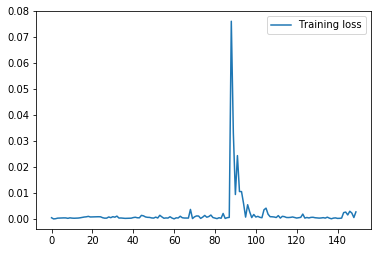

In [45]:
learning_rate = 1e-2
num_epochs = 150

model = LSTM(input_dim= input_size, hidden_dim=256, output_dim=1, num_layers=2).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
max_grad_norm = 1.0

# Train model

hist = np.zeros(num_epochs)
batch_size = 50
for t in range(num_epochs):
    for b in range(int(train_num / batch_size)):
        lstm_hidden = model.init_hidden(batch_size=batch_size)
        #loss_fn = torch.nn.MSELoss(size_average=False)
        lstm_input = X_train[batch_size*b:batch_size*(b+1), :, :]
        lstm_out, lstm_hidden = model(lstm_input, lstm_hidden)
        
        target = y_train[batch_size*b:batch_size*(b+1), :, :].float()

#         loss = torch.nn.MSELoss()(lstm_out, target)
        loss = torch.nn.MSELoss()(lstm_out[:,-1:,:], target)

        optimiser.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimiser.step()
        
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()


plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

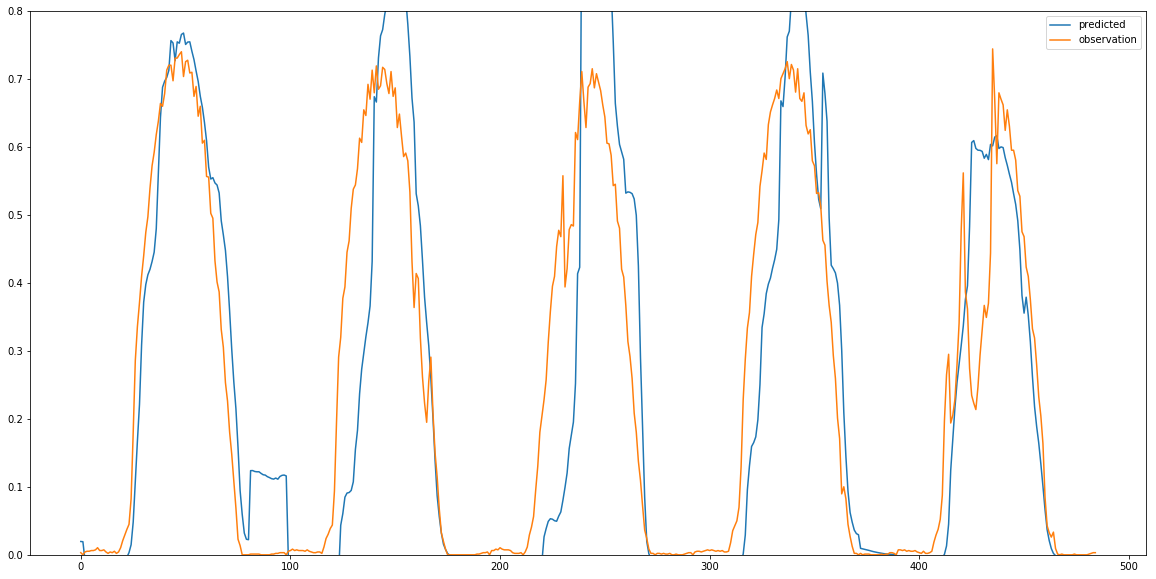

In [37]:
one_day = 97
day_len = 5

lstm_hidden = model.init_hidden(batch_size = one_day* day_len)
y_pred = model(X_test[2827:2827+one_day*day_len], lstm_hidden)
plt.figure(figsize=(20,10))
plt.plot(y_pred[0].cpu().detach().numpy().flatten(), label = 'predicted')
plt.plot(y_test[2827:2827+one_day*day_len].squeeze().cpu().numpy(), label = 'observation')
plt.ylim([0,0.8])
plt.legend()
plt.show()

# No date, time

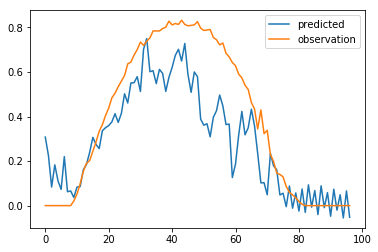

In [22]:
lstm_hidden = model.init_hidden(batch_size = 1)
y_pred = model(X_train[0:1], lstm_hidden)
plt.plot(y_pred[0].cpu().detach().numpy().flatten(), label = 'predicted')
plt.plot(y_train[0].cpu().numpy(), label = 'observation')
plt.legend()

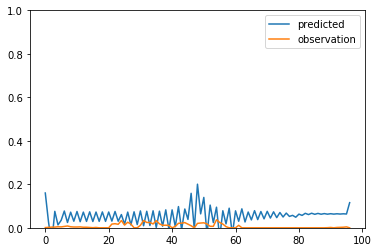

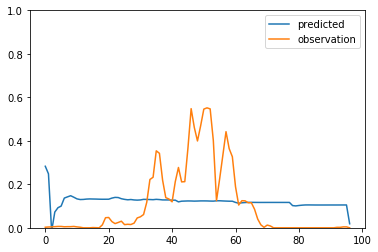

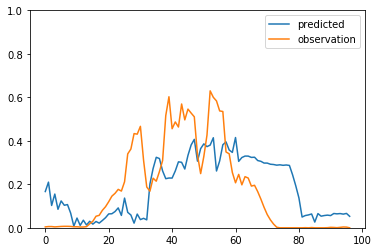

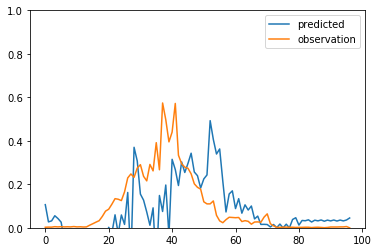

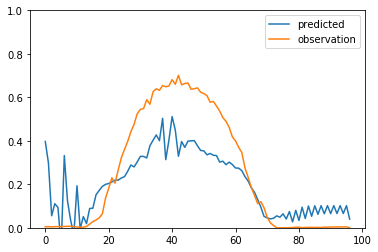

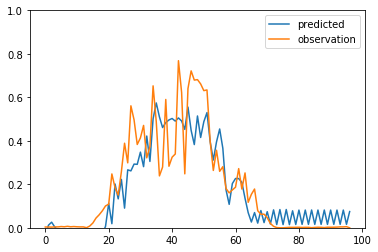

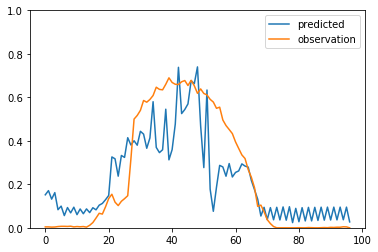

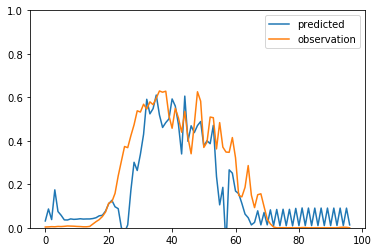

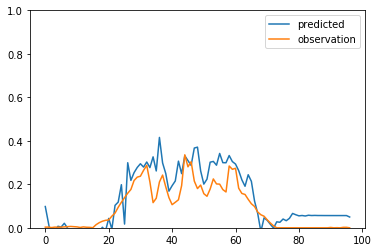

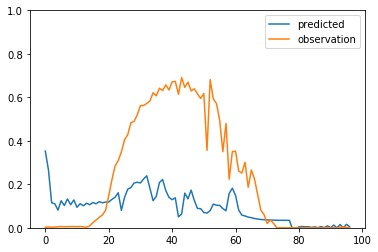

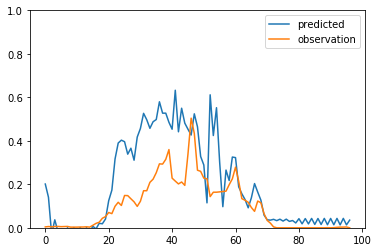

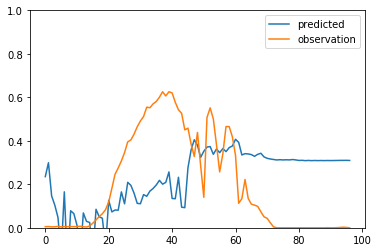

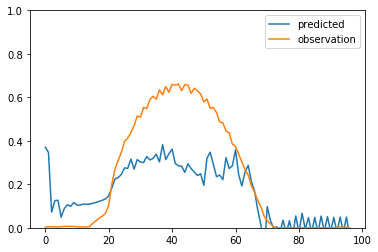

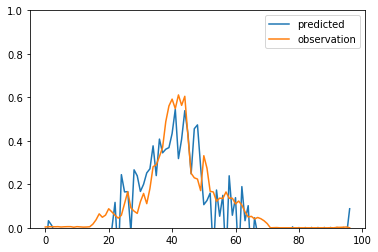

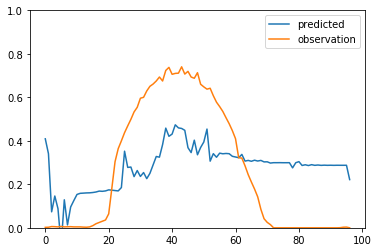

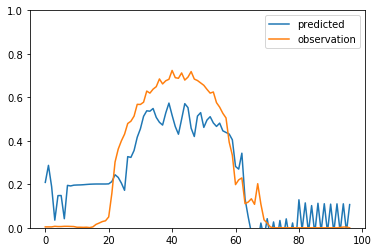

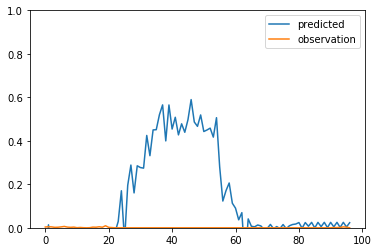

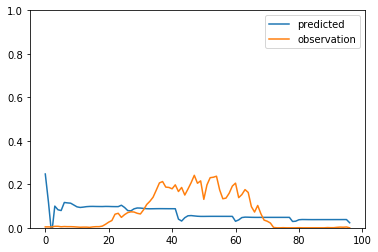

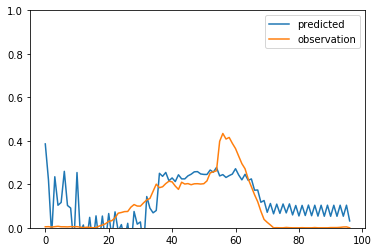

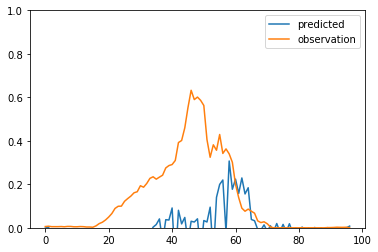

In [30]:
for i in range(20):
    lstm_hidden = model.init_hidden(batch_size = 1)
    y_pred = model(X_test[70+interval*i:71+interval*i], lstm_hidden)
    plt.plot(y_pred[0].cpu().detach().numpy().flatten(), label = 'predicted')
    plt.plot(y_test[70+interval*i].cpu().numpy(), label = 'observation')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

In [28]:
X_test[70+interval*i].shape

torch.Size([97, 11])